In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Expects timeseries.py in same folder as nb. 
from fastai.vision import *
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from timeseries import TimeSeriesItem, TimeSeriesList, UCRArchive
from scipy.signal import resample
from scipy.interpolate import interp1d

In [3]:
#init UCR archive helper class
ucr = UCRArchive()

#### Step 1: Create dataloaders
To run this notebook, you'll need the archive available here <https://www.cs.ucr.edu/~eamonn/time_series_data_2018/>
The password to the archive is 'someone'. Place the unziped directory in the same location as this nb.

The UCR Time Series Classification Archive contains 128 univariate timeseries data sets, of varying lengths and number of classes. They are presorted into training and validation sets, however the ratio between the two differs wildly from set to set. Below, I combine all the data and make my own validation set, set at 30% of the total data.

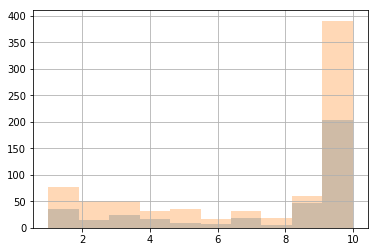

In [48]:
#Below are some datasets that seem to have good transfer properties:
#CinCECGTorso, MedicalImages, TwoPatterns, InsectWingbeatSound, UWaveGestureLibraryAll, WordSynonyms, SemgHandGenderCh2
dataset_name = "MedicalImages"
#Visualize class distribution of initial train and validation sets
vc = ucr.category_distribution(dataset_name)

In [49]:
#All input is resampled down to a length of 96
class Resample(PreProcessor):
    def process_one(self,item):
        return np.concatenate([item[[0]],resample(item[1:],96)]) if len(item) > 97 else item

In [50]:
class Resample(PreProcessor):
    def process_one(self,item):
        r = resample(item[1:],96)
        r = (r - r.mean()) / r.std()
        return np.concatenate([item[[0]],r])

In [51]:
#Here we create the classification dataset. The fastai data_block api doesn't directly support what I am trying to do, namely
#remove most of the labels AFTER creating the validation set. Thus, a bit of hackery is required. 
#Not sure about the warning, seems to be ok...

src = TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0)#,processor=Resample())
data = src.split_by_csv_name([f"{dataset_name}_TEST.tsv"])
data = data.label_from_col()
bs = min(64,len(data.x)//50)
data = data.databunch(bs=64,num_workers=0)
len(data.train_ds) #We end up with a training data set consisting of 10% of the training data as well as the full validation set

381

In [52]:
#Here we create the autocoder dataset. The differences are the data is labeled with itself, and that we use 
#the full amount of training data

src = TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0)#,processor=Resample())
dataAE = src.split_by_idx(valIdxs)
dataAE = dataAE.label_from_self()
dataAE = dataAE.databunch(bs=bs,num_workers=0)
len(dataAE.train_ds) #Should be ~10x the classification size

NameError: name 'valIdxs' is not defined

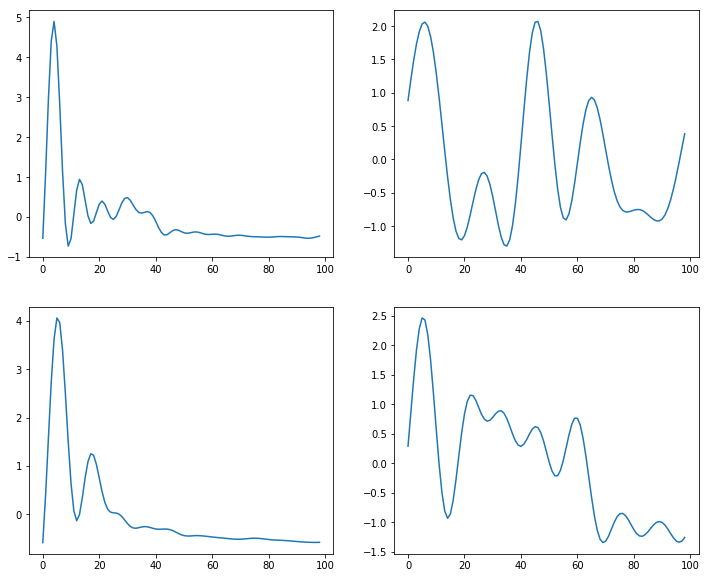

In [53]:
#Show a few inputs from the dataset
data.show_batch()

#### Step 2: Define models

In [16]:
class Gate(torch.nn.Module):
    """
    Attention Gate. Weights Attention output by its importance.
    """

    def __init__(self, in_ch, ngates=1, gate_depth=1):
        """ Constructor
        Args:
            in_ch: number of input channels.
        """
        super(Gate, self).__init__()
        if gate_depth == 1:
            self.gates = torch.nn.Linear(in_ch, ngates, bias=False)
        else:
            self.gates = torch.nn.Linear(in_ch // 2, ngates, bias=False)
            self.pre_gates = torch.nn.Linear(in_ch, in_ch // 2, bias=False)
            torch.nn.init.kaiming_normal_(self.pre_gates.weight.data)
            self.pre_bn = torch.nn.BatchNorm1d(in_ch // 2)

        torch.nn.init.kaiming_normal_(self.gates.weight.data)
        self.bn = nn.BatchNorm1d(ngates)

        self.gate_depth = gate_depth

    def forward(self, x):
        """ Pytorch forward function
        Args:
            x: input Variable
        Returns: gate value (Variable)
        """
        if self.gate_depth == 1:
            return torch.tanh(self.bn(self.gates(x)))
        else:
            return torch.tanh(self.bn(self.gates(F.relu(self.pre_bn(self.pre_gates(x))))))


class AttentionHead(torch.nn.Module):
    """ Attention Heads
    Attentds a given feature map. Provides inter-mask regularization.
    """

    def __init__(self, in_ch, nheads=1):
        """ Constructor
        Args:
            in_ch: input feature map channels
            nheads: number of attention masks
        """
        super(AttentionHead, self).__init__()
        self.nheads = nheads
        self.conv = torch.nn.Conv1d(in_ch, nheads, kernel_size=3, padding=1, bias=False)
        torch.nn.init.kaiming_normal_(self.conv.weight.data)
        self.register_buffer("diag",
                             torch.from_numpy(
                                 1 - np.eye(self.nheads, self.nheads).reshape(1, self.nheads, self.nheads)).float())

    def reg_loss(self):
        """ Regularization Loss
        Returns: a Variable with the inter-head regularization loss.
        """
        mask2loss = self.att_mask.view(self.att_mask.size(0), self.nheads, -1)
        reg_loss = torch.bmm(mask2loss, mask2loss.transpose(1, 2)) * torch.autograd.Variable(self.diag,
                                                                                             requires_grad=False)
        return (reg_loss.view(-1) ** 2).mean()

    def forward(self, x):
        """ Pytorch Forward
        Args:
            x: input feature map
        Returns: the multiple attended feature maps
        """
        b, c, l = x.size()
        att_mask = F.softmax(self.conv(x).view(b, self.nheads, l), 2).view(b, self.nheads, l)
        self.att_mask = F.avg_pool1d(att_mask, 2, 2)
        return att_mask


class OutHead(torch.nn.Module):
    """ Attention Heads
    Attentds a given feature map. Provides inter-mask regularization.
    """

    def __init__(self, in_ch, out_ch):
        """ Constructor
        Args:
            in_ch: input feature map channels
            nheads: number of attention masks
        """
        super(OutHead, self).__init__()
        self.conv = torch.nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1, bias=False)
        torch.nn.init.kaiming_normal_(self.conv.weight.data)

    def forward(self, x):
        """ Pytorch Forward
        Args:
            x: input feature map
        Returns: the multiple attended feature maps
        """
        return self.conv(x)


class AttentionModule(torch.nn.Module):
    """ Attention Module
    Applies different attention masks with the Attention Heads and ouputs classification hypotheses.
    """

    def __init__(self, in_ch, nlabels, nheads=1, reg_w=0.0, self_attention=True):
        """ Constructor
        Args:
            in_ch: number of input feature map channels
            h: input feature map height
            w: input feature map width
            nlabels: number of output classes
            nheads: number of attention heads
            has_gates: whether to use gating (recommended)
            reg_w: inter-mask regularization weight
        """
        super(AttentionModule, self).__init__()
        self.in_ch = in_ch
        self.nlabels = nlabels
        self.nheads = nheads
        self.reg_w = reg_w
        self.self_attention = self_attention

        self.att_head = AttentionHead(in_ch, nheads)
        self.out_head = OutHead(in_ch, nlabels * nheads)
        if self.self_attention:
            self.score = OutHead(in_ch, nheads)

    def reg_loss(self):
        """ Regularization loss
        Returns: A Variable with the inter-mask regularization loss for this  Attention Module.
        """
        return self.att_head.reg_loss() * self.reg_w

    def forward(self, x):
        """ Pytorch Forward
        Args:
            x: input feature map.
        Returns: tuple with predictions and gates. Gets are set to None if disabled.
        """
        b, c, l = x.size()
        att_mask = self.att_head(x).view(b, self.nheads, 1, l)
        output = (self.out_head(x).view(b, self.nheads, self.nlabels, l) * att_mask).sum(3)
        if self.self_attention:
            scores = self.score(x).view(b, self.nheads, 1, l)
            scores = (scores * att_mask).sum(3)
            scores = F.softmax(torch.tanh(scores), 1)
            return (output * scores).sum(1, keepdim=True), att_mask
        else:
            return output

    @staticmethod
    def aggregate(outputs, gates, function='softmax'):
        """ Generates the final output after aggregating all the attention modules.
        Args:
            last_output: network output logits
            last_gate: gate for the network output
        Returns: final network prediction
        """
        outputs = torch.cat(outputs, 1)
        outputs = F.log_softmax(outputs, dim=2)
        if gates is not None:
            if function == 'softmax':
                gates = F.softmax(gates, 1).view(gates.size(0), -1, 1)
                ret = (outputs * gates).sum(1)
            else:
                gates = F.sigmoid(gates).view(gates.size(0), -1, 1)
                ret = (outputs * gates).sum(1) / (1e-6 + gates.sum(1))
        else:
            ret = outputs.mean(1)

        return ret

In [17]:
#Helper functions, modified to 1d from fastai
def create_head_1d(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

def conv1d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=False, init:LayerFunc=nn.init.kaiming_normal_) -> nn.Conv1d:
    "Create and initialize `nn.Conv1d` layer. `padding` defaults to `ks//2`."
    if padding is None: padding = ks//2
    return init_default(nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias), init)

In [18]:
#This is the hero network, which serves as a backbone to all the other models
class HeroConvnet(nn.Module):
    def __init__(self, num_layers=3, start_nf=16):
        super().__init__()
        
        layers = [nn.Sequential(conv1d(1,start_nf,3,1),nn.ReLU())] #First layer is stride 1, creates initial set of filters
        nf = start_nf
        self.nfa = [nf]
        for _ in range(num_layers): #Then num_layers stride 2 convs, doubling the number of filters each layer
            layers.append(nn.Sequential(conv1d(nf,nf*2,3,2),nn.ReLU()))
            nf *= 2
            self.nfa.append(nf)
        
        self.nf = nf
        self.layers = nn.ModuleList(layers)
        self.avg = nn.AdaptiveAvgPool1d(1)
            
            
    def forward(self, x):
        actvns = [x]
        
        for l in self.layers:
            actvns.append(l(actvns[-1]))

        return self.avg(actvns[-1]), actvns[1:]

In [19]:
class AttnConvnet(nn.Module):
    def __init__(self, num_classes, num_layers=3, start_nf=16,reg_w = 0.001,num_heads=1):
        super().__init__()
        self.reg_w = reg_w
        
        self.hero = HeroConvnet(num_layers,start_nf)
        
        attnLayers = [AttentionModule(nf,num_classes,num_heads,reg_w) for nf in self.hero.nfa]
        
        self.attnLayers = nn.ModuleList(attnLayers)
        self.output_gate = Gate(self.hero.nf,num_layers+2,gate_depth=1)
        self.avg = nn.AdaptiveAvgPool1d(1)
        self.classifier = create_head_1d(self.hero.nf,num_classes,ps=0.0)    
    
    def reg_loss(self):
        """ Compute regularization loss
        Returns: the total accumulated reg loss of the network
        """
        loss = 0.0
        for l in self.attnLayers:
            loss += l.reg_loss()
        return loss / len(self.attnLayers)      
    
    def forward(self, x):
        x = x.unsqueeze(1)
        
        pt, actvns = self.hero(x)
        
        attn_outputs = [l(a) for l,a in zip(self.attnLayers,actvns)]
        self.attns = [a[1] for a in attn_outputs]
        attn_outputs = [a[0] for a in attn_outputs]
        self.attn_outputs = attn_outputs

        o = self.avg(actvns[-1]).squeeze(-1)
        gates = self.output_gate(o)
        self.gates = gates
        
        attn_outputs.append(self.classifier(o).unsqueeze(1))

        ret = AttentionModule.aggregate(attn_outputs,gates,"softmax")
        
        reg_loss = None
        if self.training and self.reg_w > 0:
            reg_loss = self.reg_loss()

        return ret, reg_loss

In [20]:
class BasicClassifier(nn.Module):
    def __init__(self,numClasses,num_layers=3,start_nf=16):
        super().__init__()
        self.conv = HeroConvnet(num_layers,start_nf)
        self.out = create_head_1d(self.conv.nf,numClasses,ps=0.0)
              
    def forward(self,ts):
        ts = self.conv(ts.unsqueeze(1))[0].squeeze(-1)
        return self.out(ts)

In [21]:
#Basic variational autoencoder with hero net serving as encoder and a few linear layers as decoder
class TSAutoencoder(nn.Module):
    def __init__(self,seqLen,latentDim=12,num_layers=3,start_nf=16):
        super().__init__()
        self.conv = HeroConvnet(num_layers,start_nf)
        self.mean = torch.nn.Linear(self.conv.nf,latentDim)
        self.logvar = torch.nn.Linear(self.conv.nf,latentDim)
        self.out = create_head_1d(latentDim,seqLen,lin_ftrs=[256,512],ps=0.0)

    def forward(self,ts):
        seqLen = ts.shape[1]
        ts, _ = self.conv(ts.unsqueeze(1))
        ts = ts.squeeze(-1)

        mean, logvar = self.mean(ts), self.logvar(ts)
          
        ls = mean
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            ls = eps.mul(std).add_(mean)        
        return self.out(ls), mean, logvar

#### Step 3: Get Baseline

In [70]:
learnBase = Learner(data,BasicClassifier(data.train_ds.c,8,8),loss_func=F.cross_entropy,metrics=[accuracy])

In [71]:
# Run one batch through the model to make sure the output size is correct
learnBase.model(next(iter(data.train_dl))[0]).size()

torch.Size([64, 10])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


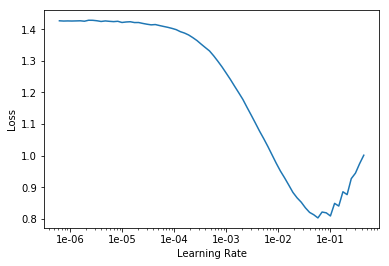

In [344]:
#Learning rate finder
learnBase.lr_find()
learnBase.recorder.plot()

In [73]:
learnBase.fit_one_cycle(20,1e-3,wd=0.2)

epoch,train_loss,valid_loss,accuracy
1,0.135485,0.916641,0.722368
2,0.141051,0.916686,0.718421
3,0.132802,0.925786,0.722368
4,0.127616,0.941295,0.723684
5,0.126547,0.947022,0.710526
6,0.129381,0.967645,0.718421
7,0.127217,0.957238,0.721053
8,0.123259,0.984914,0.718421
9,0.119221,0.981357,0.707895
10,0.115052,0.979371,0.717105


In [74]:
def loss(preds,target):
    p, rl = preds
    return rl + F.nll_loss(p,target) if rl else F.nll_loss(p,target)

In [75]:
def myacc(preds,target):
    return accuracy(preds[0],target)

In [81]:
learnAttnBase = Learner(data,AttnConvnet(data.train_ds.c,8,8,num_heads=3),loss_func=loss,metrics=[myacc])
learnAttnBase.split([learnAttnBase.model.hero,learnAttnBase.model.attnLayers[0]])

In [45]:
learnAttnBase.model(next(iter(data.train_dl))[0])[0].size()

torch.Size([64, 42])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


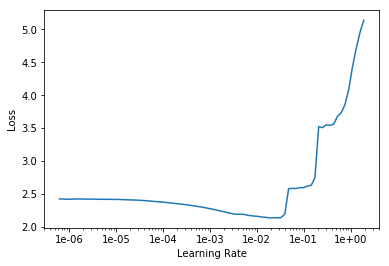

In [170]:
learnAttnBase.lr_find()
learnAttnBase.recorder.plot()

In [82]:
learnAttnBase.model.hero.load_state_dict(learnBase.model.conv.state_dict())

In [78]:
learnAttnBase.freeze_to(1)

In [84]:
learnAttnBase.fit_one_cycle(20,1e-4,wd=0.2)

epoch,train_loss,valid_loss,myacc
1,0.781596,1.312296,0.706579
2,0.756454,1.312393,0.705263
3,0.755227,1.314799,0.692105
4,0.750385,1.319720,0.706579
5,0.744140,1.312887,0.694737
6,0.737311,1.322580,0.703947
7,0.733867,1.309544,0.681579
8,0.734428,1.353673,0.702632
9,0.729849,1.328056,0.682895
10,0.725869,1.345012,0.707895


In [29]:
def upscale(a,seqLen):
    x = np.arange(seqLen)
    xp = np.linspace(0,seqLen,a.shape[1])
    f = interp1d(xp,a,kind="nearest")
    return f(x)

In [30]:
x,y = next(iter(data.train_dl))
preds, _ = learnAttnBase.model(x)
gates = torch.softmax(learnAttnBase.model.gates,dim=1).cpu().detach().numpy()
attns = [a.view(x.shape[0],-1).cpu().detach().numpy() for a in learnAttnBase.model.attns]
attns = [upscale(a,len(data.train_ds[0][0].data)) for a in attns if a.shape[1] > 1]
preds = [a.squeeze(1).cpu().detach().numpy() for a in learnAttnBase.model.attn_outputs]

attns0 = np.stack([a[0] for a in attns])
# fig, axes = plt.subplots(4,4,figsize=(16,14))
# for g, ax in zip(gates,axes.flatten()):
#     ax.plot(g)

In [31]:
gates.shape

(64, 10)

Actual Class: 4


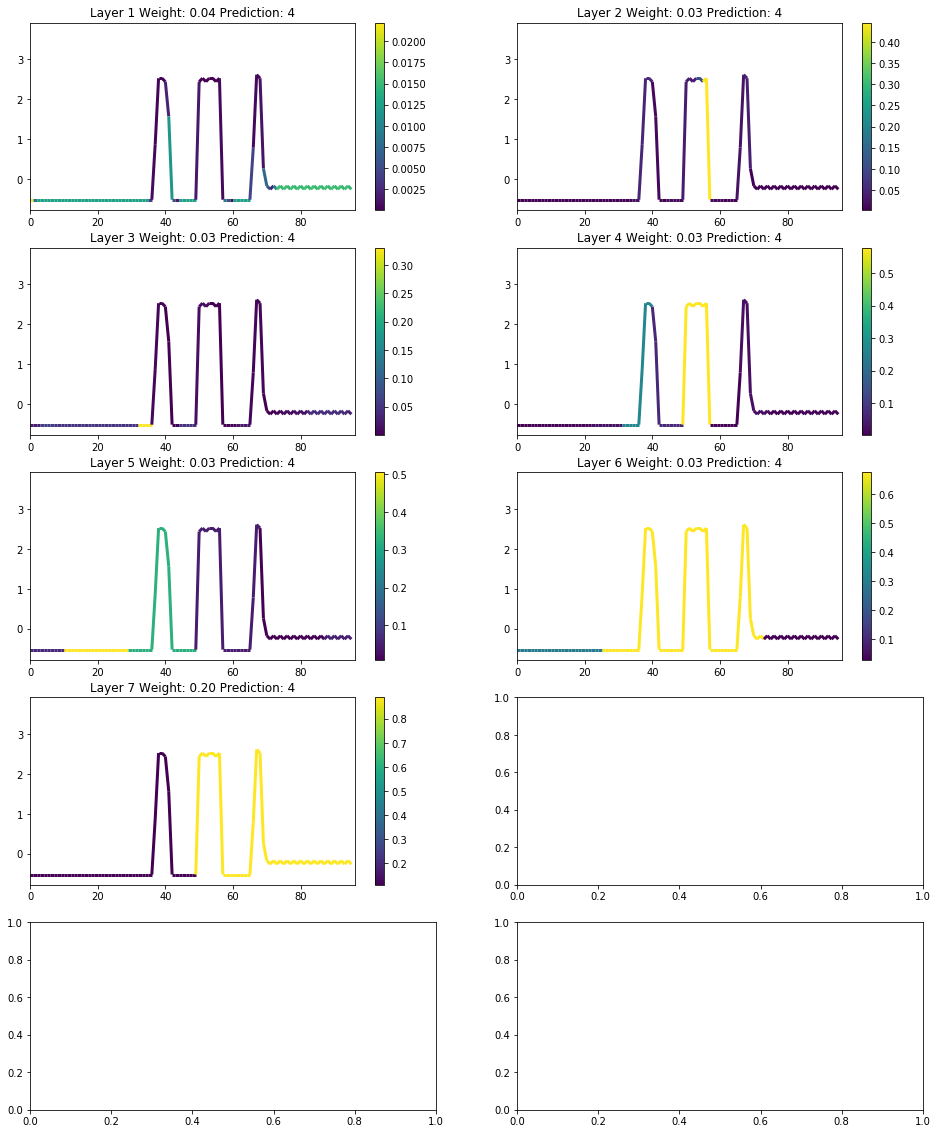

In [32]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

fig, axs = plt.subplots(5,2,figsize=(16,20))
print(f"Actual Class: {y[0].item()}")
for layer,ax in zip(range(len(attns0)),axs.flatten()):
    px = np.arange(len(attns0[layer]))
    py = x[0].cpu().detach().numpy()
    pc = attns0[layer]

    points = np.array([px,py]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]],axis=1)


    norm = plt.Normalize(pc.min(),pc.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(pc)
    lc.set_linewidth(3)
    line = ax.add_collection(lc)
    fig.colorbar(line, ax=ax)
    ax.set_xlim(0,len(py))
    ax.set_ylim(py.min()*1.5,py.max()*1.5)
    ax.set_title(f"Layer {layer+1} Weight: {gates[0,layer]:.2f} Prediction: {preds[layer][0].argmax()}")

#### Step 4: Autoencoder

In [281]:
class VAELoss(torch.nn.Module):
    def __init__(self,beta=1.0):
        super().__init__()
        self.beta = beta
    def forward(self,p,target):
        pred,mean,logvar = p
        self.mse = torch.nn.functional.mse_loss(pred,target,reduction="sum")
        self.kld = self.beta * -0.5 * torch.sum(1+logvar-mean.pow(2)-logvar.exp())
        return self.mse + self.kld

In [282]:
learnAE = Learner(dataAE,TSAutoencoder(len(data.train_ds[0][0].data),latentDim=12,num_layers=8,start_nf=8),loss_func=VAELoss())

In [283]:
learnAE.model(next(iter(data.train_dl))[0])[0].size()

torch.Size([62, 945])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


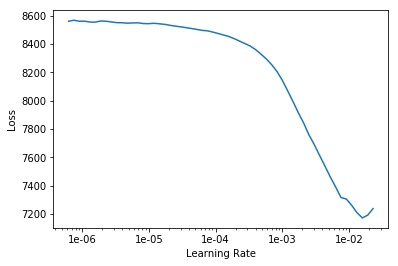

In [151]:
learnAE.lr_find()
learnAE.recorder.plot()

In [284]:
learnAE.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss
1,58882.015625,50061.035156
2,42882.687500,29144.880859
3,30390.847656,21070.304688
4,22403.906250,16150.958008
5,17847.810547,15060.539062
6,15445.252930,12641.111328
7,14047.736328,11713.883789
8,13077.000000,11569.955078
9,12568.230469,11453.690430
10,12095.912109,11003.008789


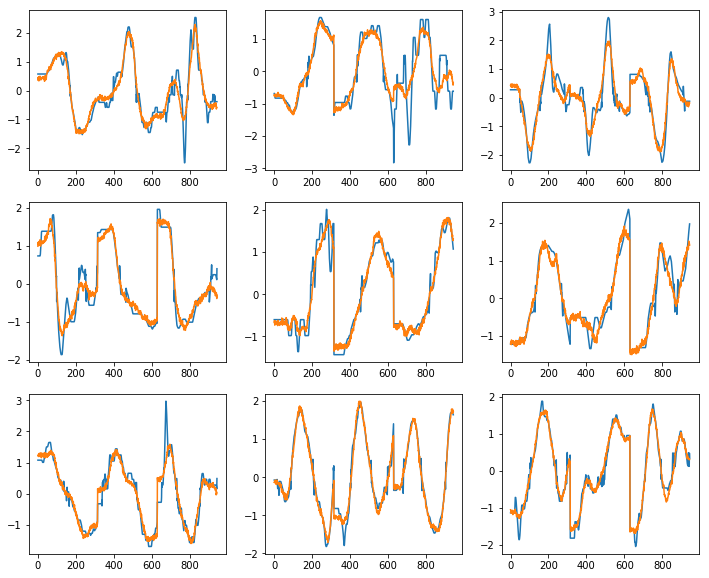

In [285]:
learnAE.show_results(DatasetType.Train,rows=9)

In [208]:
#Optional: Visualize latent space
learnAE.model.eval()
out = []
classes = []
with torch.no_grad():
    for x,y in iter(data.valid_dl):
        ls = learnAE.model.mean(learnAE.model.conv(x.unsqueeze(1))[0].squeeze(-1))
        out.append(ls)
        classes.append(y)
out = torch.cat(out).cpu().detach().numpy()
classes = torch.cat(classes).cpu().detach().numpy()

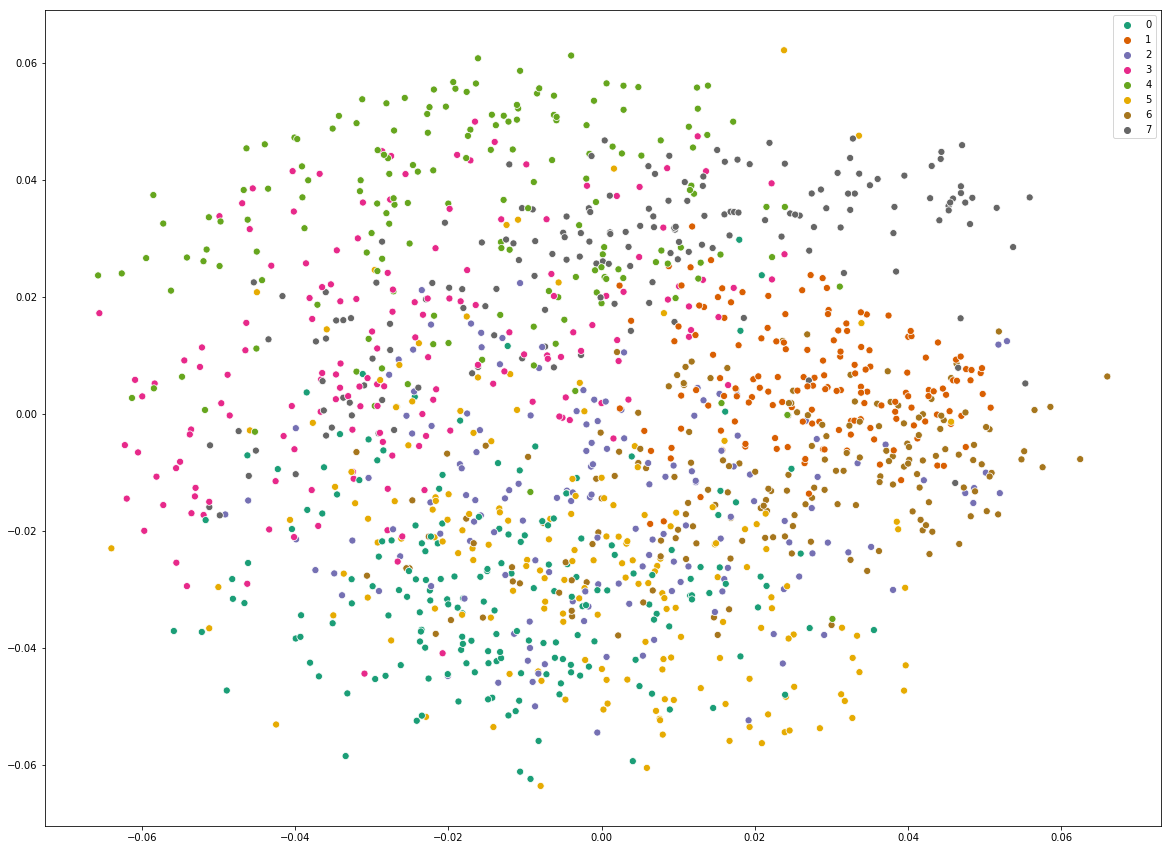

In [209]:
pca = PCA(n_components=2)
f = pca.fit(out.T)
f = f.components_.T
plt.subplots(figsize=(20,15))
style = classes if data.train_ds.c < 8 else None
sns.scatterplot(x=f[:,0],y=f[:,1],hue=classes,palette="Dark2",style=style,legend="full",s=50)

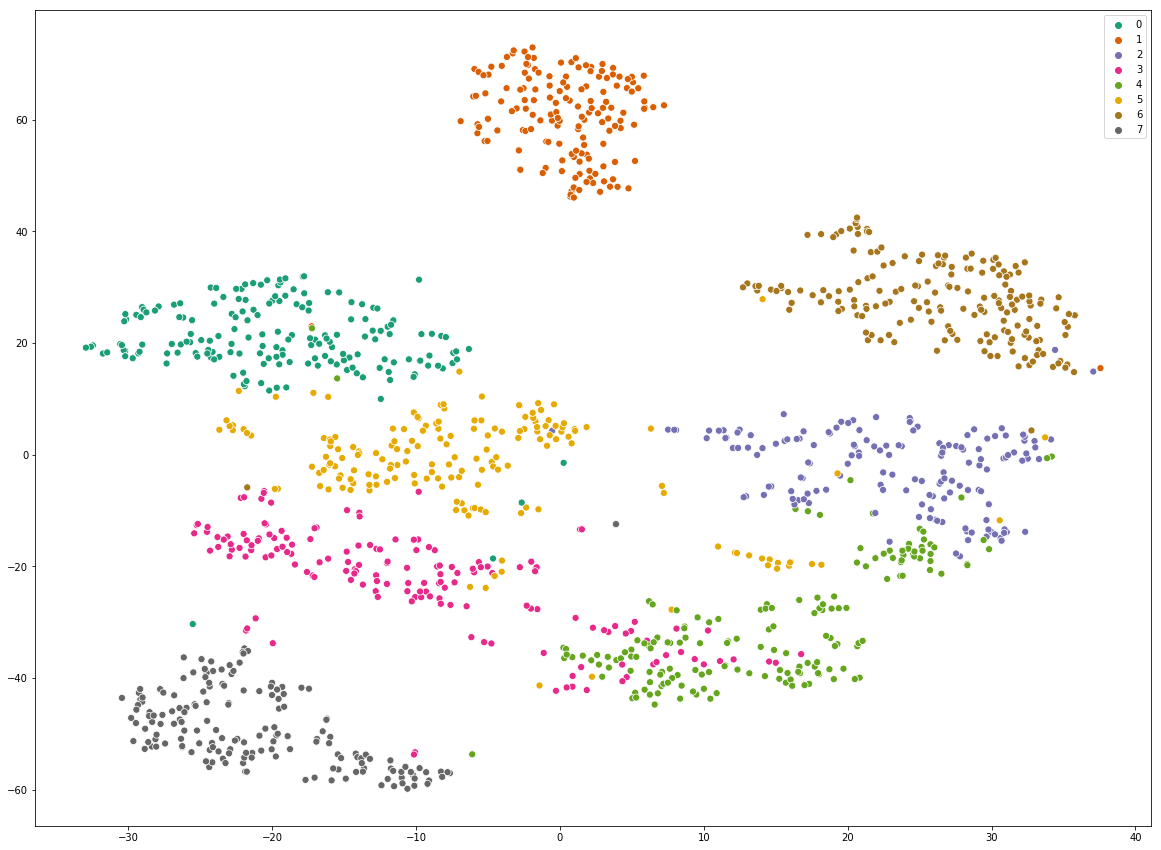

In [210]:
tsne = TSNE(n_components=2)
f = tsne.fit_transform(out)
plt.subplots(figsize=(20,15))
sns.scatterplot(x=f[:,0],y=f[:,1],hue=classes,palette="Dark2",style=style,legend="full",s=50)

#### Step 5: Traditional transfer
Here we train a classifier by just adding a classifier head onto the encoder from the previous step

In [211]:
learnDT = Learner(data,BasicClassifier(data.train_ds.c,8,8),loss_func=F.cross_entropy,metrics=[accuracy],
                 callback_fns=BnFreeze,bn_wd=False,train_bn=False)
learnDT.split([*learnDT.model.conv.layers,learnDT.model.conv.avg,learnDT.model.out])

In [212]:
#Load the parameters from the encoder
learnDT.model.conv.load_state_dict(learnAE.model.conv.state_dict())

In [213]:
#Freeze up to the classifier layer
learnDT.freeze_to(-1)

In [214]:
learnDT.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.984411,2.073569,0.124348
2,1.690443,2.048832,0.403574
3,1.341964,1.970334,0.809382
4,1.073349,1.804172,0.875652
5,0.882632,1.550877,0.880864
6,0.739046,1.267667,0.900968
7,0.626978,1.017668,0.912882
8,0.536780,0.816888,0.912882
9,0.465371,0.650566,0.913626
10,0.405443,0.517747,0.924795


In [215]:
#Fine tune
learnDT.unfreeze()
learnDT.fit_one_cycle(20,1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.035690,0.249084,0.937453
2,0.031238,0.248274,0.938943
3,0.030779,0.247034,0.938943
4,0.030340,0.246126,0.938198
5,0.028991,0.247311,0.936709
6,0.027741,0.247572,0.937453
7,0.026626,0.244600,0.940432
8,0.025261,0.243900,0.937453
9,0.024375,0.242838,0.936709
10,0.022992,0.243722,0.935220


#### Step 6: Sidekick network

In [286]:
learnSidekick = Learner(data,AttnConvnet(data.train_ds.c,num_layers=8,start_nf=8,reg_w=0.0001), loss_func=loss,metrics=[myacc],
                        callback_fns=BnFreeze,bn_wd=False,train_bn=False)
learnSidekick.split([learnSidekick.model.hero,learnSidekick.model.attnLayers[0],learnSidekick.model.classifier])

In [287]:
learnSidekick.model(next(iter(data.train_dl))[0])[0].size()

torch.Size([62, 8])

In [288]:
learnSidekick.model.hero.load_state_dict(learnAE.model.conv.state_dict())
learnSidekick.freeze_to(1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


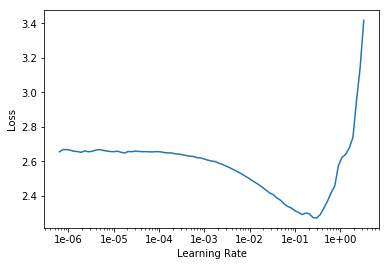

In [128]:
learnSidekick.lr_find()
learnSidekick.recorder.plot()

In [230]:
learnSidekick.unfreeze()

In [289]:
learnSidekick.fit_one_cycle(20,1e-3,wd=0.2)

epoch,train_loss,valid_loss,myacc
1,2.271718,2.292525,0.131050
2,2.206862,2.225425,0.136262
3,2.130268,2.091275,0.439315
4,2.056711,1.910400,0.636634
5,1.985573,1.769068,0.755771
6,1.916973,1.674724,0.841400
7,1.854006,1.598933,0.860759
8,1.797673,1.539633,0.889054
9,1.745733,1.495425,0.901713
10,1.699160,1.463658,0.900968


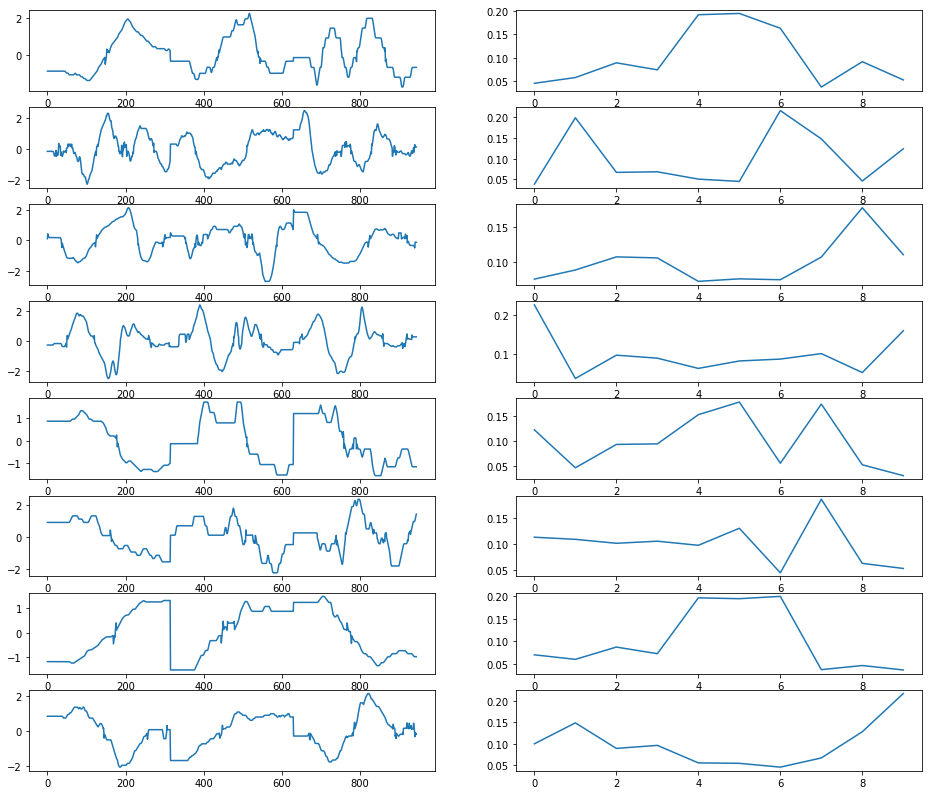

In [297]:
x,y = next(iter(data.train_dl))
preds, _ = learnSidekick.model(x)
gates = torch.softmax(learnSidekick.model.gates,dim=1).cpu().detach().numpy()
fig, axes = plt.subplots(8,2,figsize=(16,14))
for ts, g, ax in zip(x,gates,axes):
     ax[0].plot(ts)
     ax[1].plot(g)